Use GPyTorch
Use Spectral Mixture kernel
https://docs.gpytorch.ai/en/latest/examples/01_Exact_GPs/Spectral_Mixture_GP_Regression.html

In [2]:
import math
import torch
import gpytorch
%load_ext autoreload
%autoreload 2

import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# GPy: Gaussian processes library
import GPy

import pandas as pd
pd.set_option('precision', 0)
pd.set_option('display.float_format', lambda x: '%.16f' % x)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Make the notebook use the whole screen width
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

Read the first time series

In [4]:
df = pd.read_csv("../data/sim_pulse.lc",sep=' ', header = None, names=['Time', 'Lc'], index_col=False, float_precision='round_trip')
df.dtypes

Time    float64
Lc      float64
dtype: object

In [5]:
# Print first and last lines of the dataset
#df.style.format('{:.16f}')
#df

In [6]:
X, Y = df['Time'].tolist(), df['Lc'].tolist()
X, Y = np.array(X), np.array(Y)

# 1. Exploratory

Zoomed in on the first N observations

In [7]:
N=1500

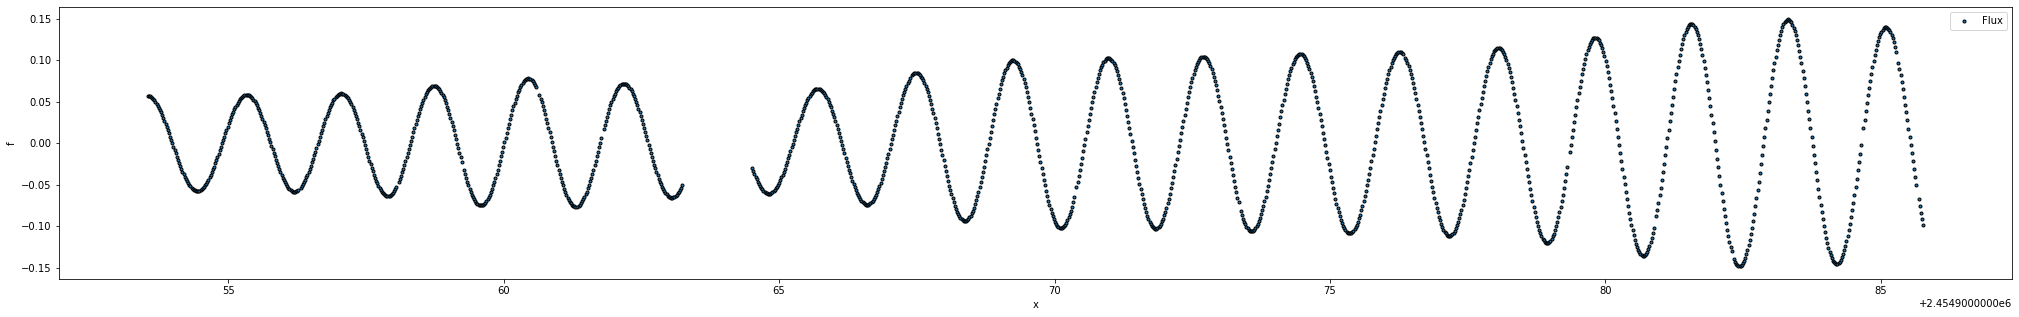

In [8]:
# Setup our figure environment
plt.figure(figsize=(35, 5))

# Plot observations
plt.plot(X[:N], Y[:N], ".", mew=1, linewidth=1, mec="black")

# Annotate plot
plt.xlabel("x"), plt.ylabel("f")
plt.legend(labels=["Flux"]);

# 2. Processing


Compose a Gaussian Process from a reasonable guess of kernels

In [9]:
train_x=torch.tensor(X[:N])
train_y=torch.tensor(Y[:N])

In [10]:
train_x,train_y

(tensor([2454953.5392, 2454953.5597, 2454953.5801,  ..., 2454985.7231,
         2454985.7435, 2454985.7639], dtype=torch.float64),
 tensor([ 0.0570,  0.0568,  0.0563,  ..., -0.0838, -0.0913, -0.0982],
        dtype=torch.float64))

In [11]:
NUM_MIXTURES=4

In [12]:
class SpectralMixtureGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(SpectralMixtureGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=NUM_MIXTURES)
        self.covar_module.initialize_from_data(train_x, train_y)

    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = SpectralMixtureGPModel(train_x, train_y, likelihood)

# As we are using float64 data, we need to convert our model to double
model.double()
likelihood.double()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [13]:
training_iter = 20 if smoke_test else 50

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   period: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        0,
#        model.covar_module.base_kernel.period_length.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()
    # Why is this needed??
    if loss.item() < 0:
        break

Iter 1/20 - Loss: 0.763   period: 0.000   noise: 0.693
Iter 2/20 - Loss: 0.759   period: 0.000   noise: 0.688
Iter 3/20 - Loss: 0.758   period: 0.000   noise: 0.683
Iter 4/20 - Loss: 0.753   period: 0.000   noise: 0.678
Iter 5/20 - Loss: 0.750   period: 0.000   noise: 0.673
Iter 6/20 - Loss: 0.743   period: 0.000   noise: 0.669
Iter 7/20 - Loss: 0.744   period: 0.000   noise: 0.664
Iter 8/20 - Loss: 0.737   period: 0.000   noise: 0.659
Iter 9/20 - Loss: 0.737   period: 0.000   noise: 0.654
Iter 10/20 - Loss: 0.733   period: 0.000   noise: 0.649
Iter 11/20 - Loss: 0.730   period: 0.000   noise: 0.644
Iter 12/20 - Loss: 0.725   period: 0.000   noise: 0.640
Iter 13/20 - Loss: 0.720   period: 0.000   noise: 0.635
Iter 14/20 - Loss: 0.715   period: 0.000   noise: 0.630
Iter 15/20 - Loss: 0.712   period: 0.000   noise: 0.626
Iter 16/20 - Loss: 0.709   period: 0.000   noise: 0.621
Iter 17/20 - Loss: 0.704   period: 0.000   noise: 0.616
Iter 18/20 - Loss: 0.701   period: 0.000   noise: 0.612
I

In [14]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along train_x
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(min(train_x), max(train_x), N).double()
    observed_pred = likelihood(model(test_x))

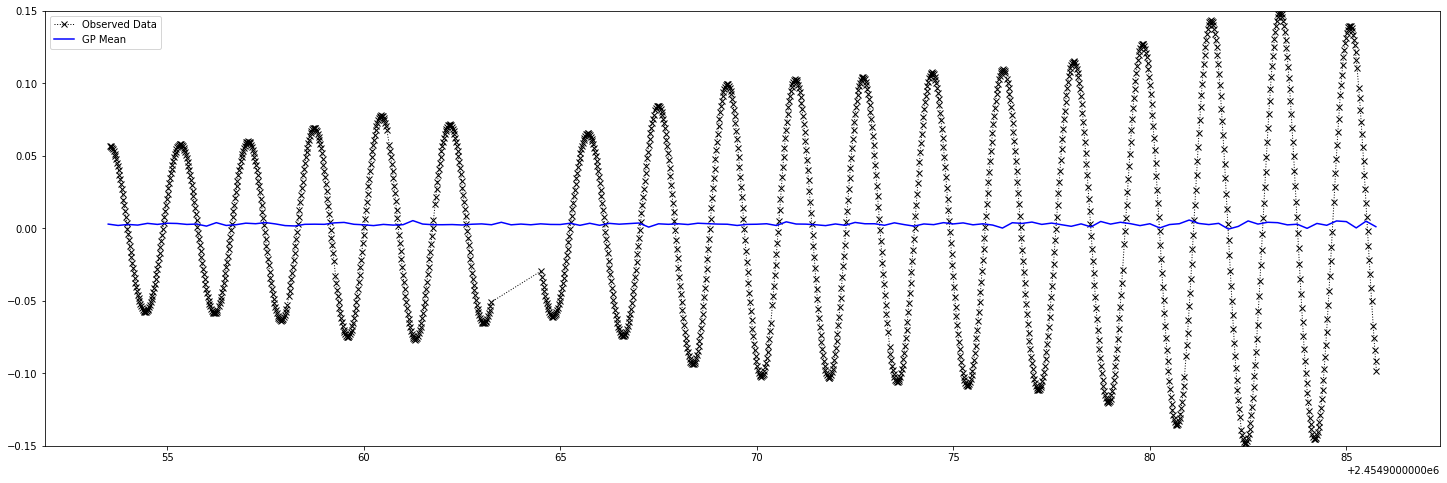

In [15]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(25, 8))

    # Get upper and lower confidence bounds
#    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), "kx:", lw=1)
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
#    # Shade between the lower and upper confidence bounds
#    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-0.15, 0.15])
    ax.legend(['Observed Data', 'GP Mean', 'Confidence'])

In [16]:
residuals = train_y-observed_pred.mean.numpy()

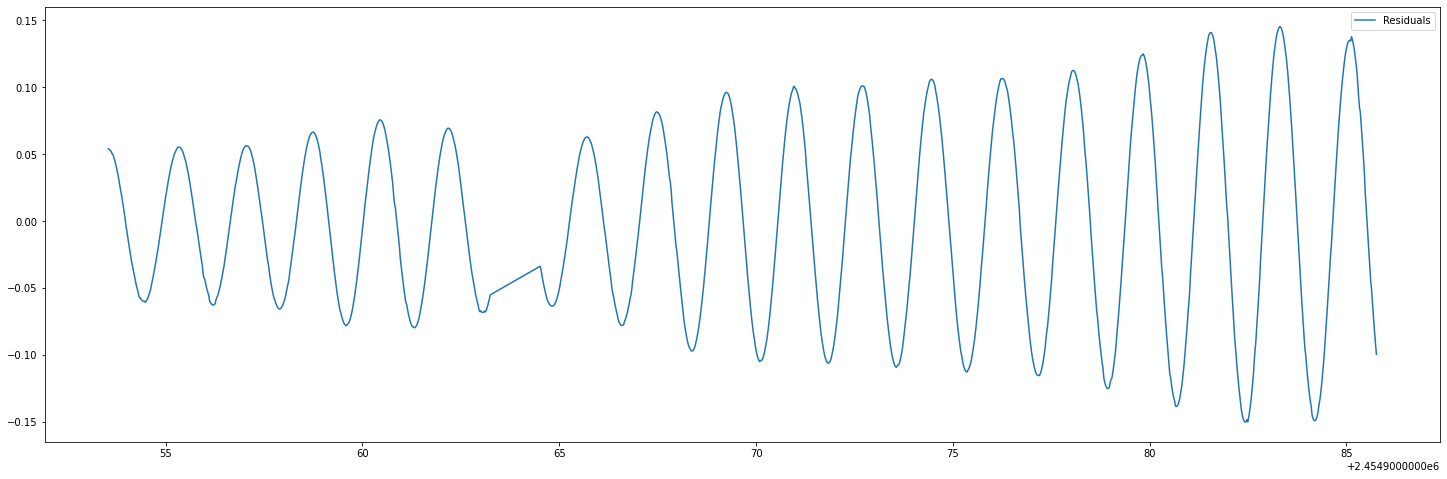

In [17]:
# Plot GP residuals
plt.figure(figsize=(25, 8))
plt.plot(train_x, residuals, "-")
plt.legend(labels=["Residuals"])